<a href="https://colab.research.google.com/github/Shobhit30/Shobhit30/blob/main/Satellite_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import json
import matplotlib.pyplot as plt
import tensorflow as tf



from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data Input

In [4]:
with open('/content/drive/MyDrive/shipsnet.json') as data_file:
    dataset = json.load(data_file)
shipsnet= pd.DataFrame(dataset)
shipsnet.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [5]:
shipsnet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       4000 non-null   object
 1   labels     4000 non-null   int64 
 2   locations  4000 non-null   object
 3   scene_ids  4000 non-null   object
dtypes: int64(1), object(3)
memory usage: 125.1+ KB


In [6]:
shipsnet = shipsnet[["data", "labels"]]
shipsnet.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [7]:
len(shipsnet["data"].iloc[0])

19200

In [8]:
ship_images = shipsnet["labels"].value_counts()[0]
no_ship_images = shipsnet["labels"].value_counts()[1]
print("Number of the ship_images :{}".format(ship_images),"\n")
print("Number of the not ship_images :{}".format(no_ship_images))

Number of the ship_images :3000 

Number of the not ship_images :1000


Reshaping

In [9]:
# Turning the json information into numpy array and then assign it as x and y variables
x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [10]:
x.shape

(4000, 19200)

In [11]:
x_reshaped = x.reshape([-1, 3, 80, 80])

x_reshaped.shape

(4000, 3, 80, 80)

In [12]:
x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
x_reshaped.shape

(4000, 80, 80, 3)

In [13]:
y.shape

(4000,)

In [14]:
y_reshaped = to_categorical(y, num_classes=2)

y_reshaped.shape

(4000, 2)

In [15]:
y_reshaped

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

Data Exploration

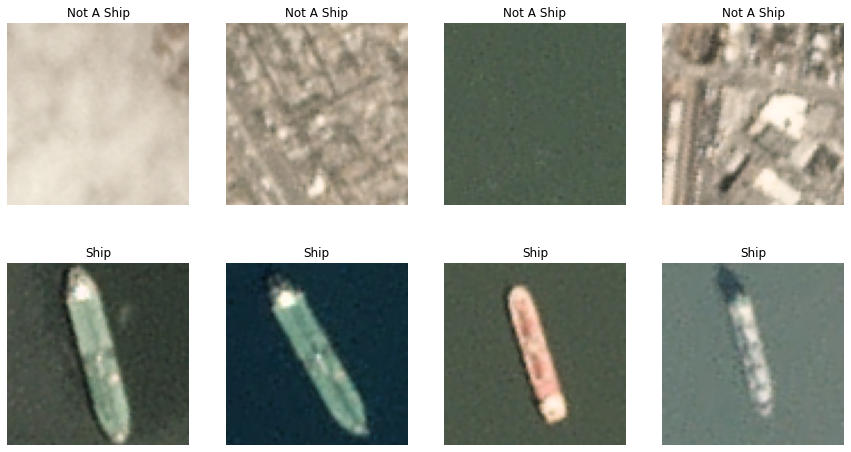

In [16]:
image_no_ship = x_reshaped[y==0]
image_ship = x_reshaped[y==1]

def plot(a,b):
    
    plt.figure(figsize=(15, 15))
    for i, k in enumerate(range(1,9)):
        if i < 4:
            plt.subplot(2,4,k)
            plt.title('Not A Ship')
            plt.imshow(image_no_ship[i+2])
            plt.axis("off")
        else:
            plt.subplot(2,4,k)
            plt.title('Ship')
            plt.imshow(image_ship[i+15])
            plt.axis("off")
            
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25)

#Implementation of the function 

plot(image_no_ship, image_ship)

Pixel Intensity exploration

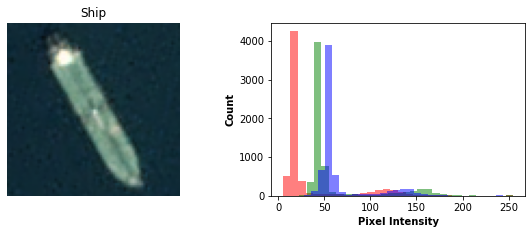

Minimum pixel value of this image: 5
Maximum pixel value of this image: 255


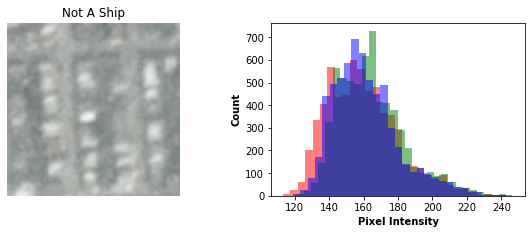

Minimum pixel value of this image: 113
Maximum pixel value of this image: 247


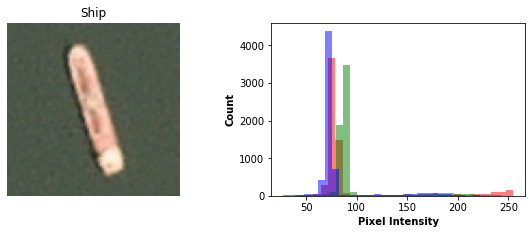

Minimum pixel value of this image: 27
Maximum pixel value of this image: 255


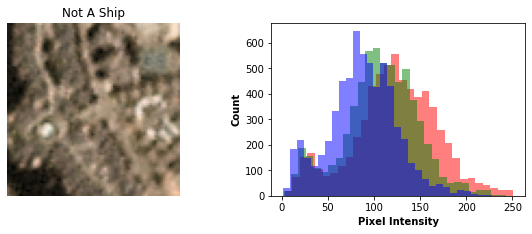

Minimum pixel value of this image: 1
Maximum pixel value of this image: 251


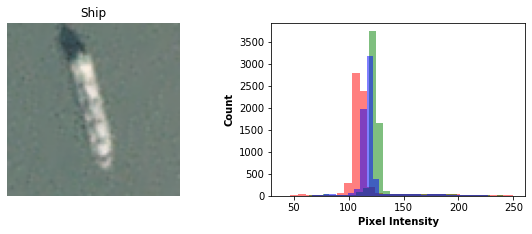

Minimum pixel value of this image: 40
Maximum pixel value of this image: 250


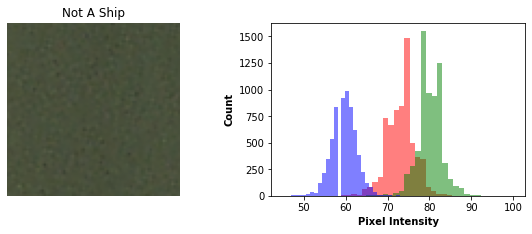

Minimum pixel value of this image: 45
Maximum pixel value of this image: 100


In [17]:
def plotHistogram(ship, not_ship):

    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(ship)
    plt.axis('off')
    plt.title('Ship')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(ship.min()))
    print("Maximum pixel value of this image: {}".format(ship.max()))
    plt.figure(figsize = (10,7))
    plt.subplot(2,2,3)
    plt.imshow(not_ship)
    plt.axis('off')
    plt.title('Not A Ship')
    histo = plt.subplot(2,2,4)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(not_ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(not_ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(not_ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(not_ship.min()))
    print("Maximum pixel value of this image: {}".format(not_ship.max()))
#Implementation of the function

for i in range (20,23):
    plotHistogram(x_reshaped[y==1][i], x_reshaped[y==0][i])

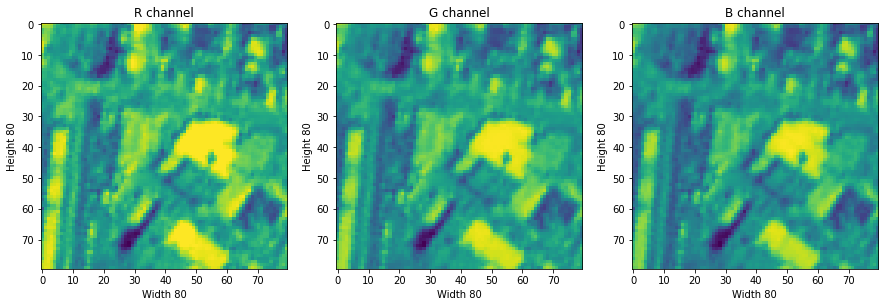

In [18]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==0][5][ : , : , i])

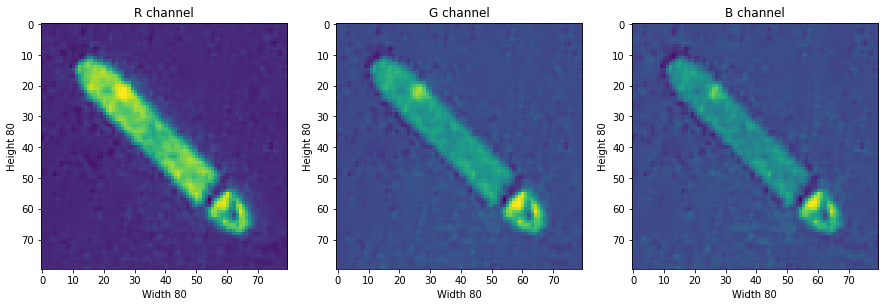

In [19]:
my_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in my_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_reshaped[y==0][5].shape[0]))
    plt.xlabel('Width {}'.format(x_reshaped[y==0][5].shape[1]))
    plt.imshow(x_reshaped[y==1][5][ : , : , i])

Preparing testing and training model

In [20]:
x_reshaped = x_reshaped / 255
x_reshaped[0][0][0] # Normalized RGB values of the firs pixel of the first image in the dataset.

array([0.32156863, 0.36862745, 0.31372549])

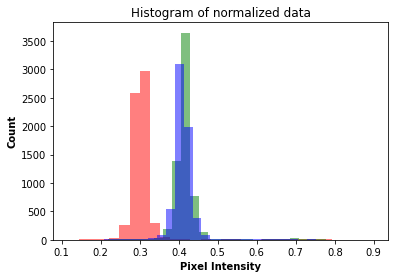

In [21]:
n_bins = 30
plt.hist(x_reshaped[y == 0][0][:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
plt.hist(x_reshaped[y == 0][0][:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
plt.ylabel('Count', fontweight = "bold")
plt.xlabel('Pixel Intensity', fontweight = "bold")
plt.title("Histogram of normalized data")
plt.show()

In [22]:
x_train_1, x_test, y_train_1, y_test = train_test_split(x_reshaped, y_reshaped,
                                                        test_size = 0.20, random_state = 42)


x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, 
                                                  test_size = 0.25, random_state = 42)


print("x_train shape",x_train.shape)
print("x_test shape",x_test.shape)
print("y_train shape",y_train.shape)
print("y_test shape",y_test.shape)
print("y_train shape",x_val.shape)
print("y_test shape",y_val.shape)

x_train shape (2400, 80, 80, 3)
x_test shape (800, 80, 80, 3)
y_train shape (2400, 2)
y_test shape (800, 2)
y_train shape (800, 80, 80, 3)
y_test shape (800, 2)


In [23]:
x_train.shape

(2400, 80, 80, 3)

CNN Implementation

In [24]:
from keras import callbacks
model = Sequential()
#
model.add(Conv2D(filters = 64, kernel_size = (4,4),padding = 'Same', 
                 activation ='relu', input_shape = (80,80,3)))
model.add(MaxPool2D(pool_size=(5,5)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (2,2),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(1,1)))
model.add(Dropout(0.25))

# Fully connected
model.add(Flatten())
model.add(Dense(200, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_val, y_val), callbacks = [earlystopping])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
75/75 [==============================] - 28s 335ms/step - loss: 0.6008 - accuracy: 0.7221 - val_loss: 0.5839 - val_accuracy: 0.7513
Epoch 2/100
75/75 [==============================] - 21s 275ms/step - loss: 0.4754 - accuracy: 0.7529 - val_loss: 0.4398 - val_accuracy: 0.7513
Epoch 3/100
75/75 [==============================] - 21s 286ms/step - loss: 0.3765 - accuracy: 0.7738 - val_loss: 0.3393 - val_accuracy: 0.8612
Epoch 4/100
75/75 [==============================] - 20s 269ms/step - loss: 0.3553 - accuracy: 0.8517 - val_loss: 0.3459 - val_accuracy: 0.8725
Epoch 5/100
75/75 [==============================] - 20s 273ms/step - loss: 0.3165 - accuracy: 0.8767 - val_loss: 0.2496 - val_accuracy: 0.8975
Epoch 6/100
75/75 [==============================] - 20s 270ms/step - loss: 0.2704 - accuracy: 0.8875 - val_loss: 0.2095 - val_accuracy: 0.9137
Epoch 7/100
75/75 [==============================] - 20s 266ms/step - loss: 0.2400 - accuracy: 0.9179 - val_loss: 0.2117 - val_accuracy:

In [25]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 2s 76ms/step - loss: 0.0416 - accuracy: 0.9837


[0.041621435433626175, 0.9837499856948853]

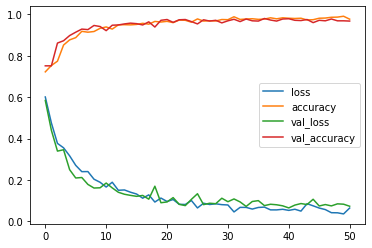

In [26]:
pd.DataFrame(history.history).plot();

In [27]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=5,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  

datagen.fit(x_train)

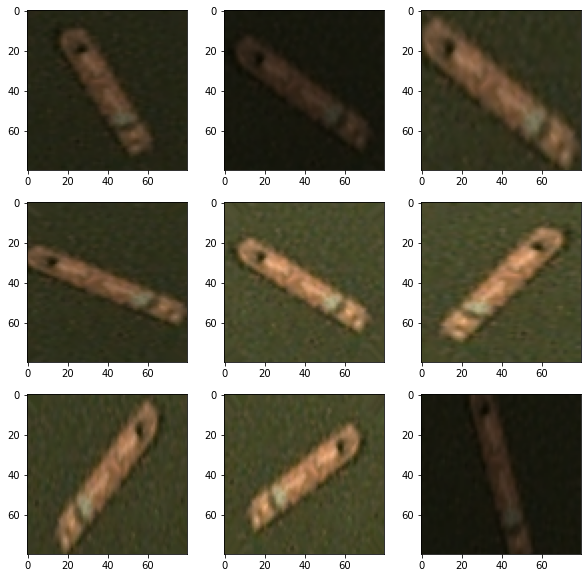

In [28]:
data = x_reshaped[y==1][15]
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datag = ImageDataGenerator(brightness_range=[0.2,1.0],
                          zoom_range=[0.5,1.0],
                          horizontal_flip=True,
                          rotation_range=90)
# prepare iterator
it = datag.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize = (10,10))
for i in range(9):
    # define subplot
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
    # show the figure
plt.show()

In [29]:
history = model.fit(datagen.flow(x_train, y_train), epochs = 100, 
                    validation_data=(x_val, y_val), callbacks = [earlystopping])

Epoch 1/100
75/75 [==============================] - 25s 324ms/step - loss: 0.2202 - accuracy: 0.9342 - val_loss: 0.1086 - val_accuracy: 0.9538
Epoch 2/100
75/75 [==============================] - 24s 322ms/step - loss: 0.1677 - accuracy: 0.9392 - val_loss: 0.1195 - val_accuracy: 0.9638
Epoch 3/100
75/75 [==============================] - 24s 319ms/step - loss: 0.1610 - accuracy: 0.9421 - val_loss: 0.1024 - val_accuracy: 0.9650
Epoch 4/100
75/75 [==============================] - 24s 320ms/step - loss: 0.1542 - accuracy: 0.9463 - val_loss: 0.1104 - val_accuracy: 0.9600
Epoch 5/100
75/75 [==============================] - 24s 320ms/step - loss: 0.1541 - accuracy: 0.9417 - val_loss: 0.1792 - val_accuracy: 0.9400
Epoch 6/100
75/75 [==============================] - 24s 319ms/step - loss: 0.1526 - accuracy: 0.9450 - val_loss: 0.1181 - val_accuracy: 0.9600
Epoch 7/100
75/75 [==============================] - 24s 316ms/step - loss: 0.1312 - accuracy: 0.9579 - val_loss: 0.0965 - val_accuracy:

In [30]:
model.evaluate(x_test, y_test)

25/25 [==============================] - 2s 67ms/step - loss: 0.0527 - accuracy: 0.9837


[0.05272804573178291, 0.9837499856948853]

Results


Test Accuracy Score :  0.98375 



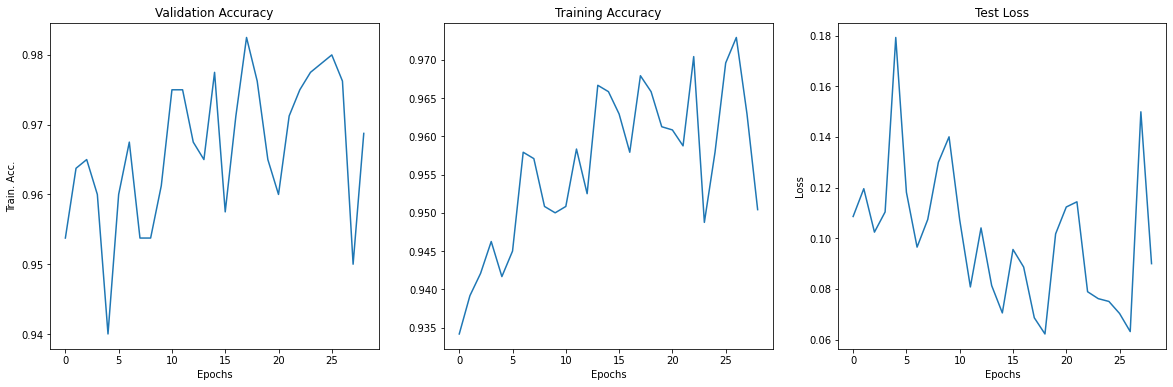

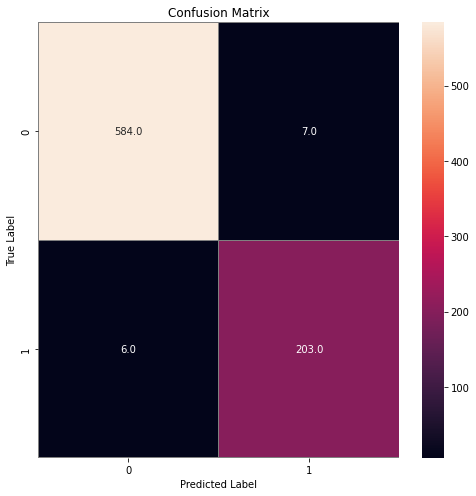

In [31]:
from sklearn import metrics
import seaborn as sns
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# Compute the confusion matrix

print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

Not A Ship    0.009768
Ship          0.990232
dtype: float32

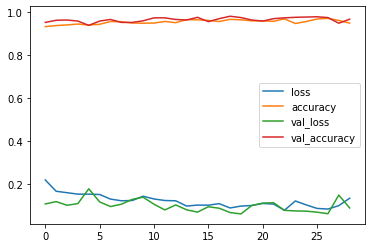

In [32]:
pd.DataFrame(history.history).plot();
prediction = model.predict(x_test)
pd.Series(prediction[0], index=["Not A Ship", "Ship"])